In [ ]:
!git remote add origin https://github.com/yoonjh25/CNN.git

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

2024-12-02 17:48:52.313970: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 17:48:52.523880: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=128, target_width=128):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=32, target_height=128, target_width=128):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # 데이터셋 전처리 매핑
    dataset = dataset.map(lambda path, label: preprocess_image(path, label, target_height, target_width),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # 데이터 셔플 및 배치
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [3]:
# 5. 학습 및 테스트 데이터셋 생성
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels, batch_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-12-02 17:48:56.800536: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 17:48:57.007385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1136 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e3:00.0, compute capability: 8.0


## CNN5

In [ ]:
model4 = tf.keras.Sequential([
    # 입력 레이어
    tf.keras.layers.Input(shape=(128, 128, 3)),
    
    # 첫 번째 합성곱 + 풀링
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # 필터 수 32
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 두 번째 합성곱 + 풀링
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # 필터 수 64
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # 글로벌 평균 풀링
    tf.keras.layers.GlobalAveragePooling2D(),

    # 완전 연결 레이어 (뉴런 수를 크게 늘림)
    tf.keras.layers.Dense(256, activation='relu'),  # 뉴런 수 증가
    tf.keras.layers.Dropout(0.3),  # 드롭아웃 비율 감소

    # 출력 레이어
    tf.keras.layers.Dense(7, activation='softmax')  # 출력 클래스 7개
])



In [ ]:
model4.summary()

In [ ]:

# 모델 컴파일
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [ ]:
result4 =model4.fit(train_dataset, validation_data=test_dataset, epochs=50)

In [ ]:
# 모델 평가
score4 = model4.evaluate(test_dataset)

In [ ]:
acc4 = result4.history['accuracy']
val_acc4 = result4.history['val_accuracy']
loss4 = result4.history['loss']
val_loss4 = result4.history['val_loss']
epochs4 = range(1, len(acc4) + 1)

# Training and validation accuracy plot
plt.plot(epochs4, acc4, 'bo', label='Training accuracy')
plt.plot(epochs4, val_acc4, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs4, loss4, 'bo', label='Training loss')
plt.plot(epochs4, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()



## CNN6

In [ ]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# 모델 컴파일
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [ ]:
model5.summary()

In [ ]:
result5 =model5.fit(train_dataset, validation_data=test_dataset, epochs=50)

In [ ]:
score5 = model5.evaluate(test_dataset)

In [ ]:
acc5 = result5.history['accuracy']
val_acc5 = result5.history['val_accuracy']
loss5 = result5.history['loss']
val_loss5 = result5.history['val_loss']
epochs5 = range(1, len(acc5) + 1)

# Training and validation accuracy plot
plt.plot(epochs5, acc5, 'bo', label='Training accuracy')
plt.plot(epochs5, val_acc5, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()       
plt.show()

# Training and validation loss plot
plt.plot(epochs5, loss5, 'bo', label='Training loss')
plt.plot(epochs5, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()     
plt.show()

## CNN 7

In [4]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),  # Softmax로 변경
])



In [5]:
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [6]:

# 모델 컴파일
model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [7]:
result6 =model6.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-02 17:50:58.625621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1720 of 11661
2024-12-02 17:51:08.626500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3535 of 11661
2024-12-02 17:51:18.637627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5219 of 11661
2024-12-02 17:51:28.628204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6877 of 11661
2024-12-02 17:51:38.628861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8535 of 11661
2024-12-02 17:51:48.626107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10223 of 11661
2024-12-02 17:51:57.392023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle

365/365 [==============================] - ETA: 0s - loss: 1.6367 - accuracy: 0.3586

2024-12-02 17:52:12.080633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1684 of 2916
2024-12-02 17:52:19.382409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 92s 56ms/step - loss: 1.6367 - accuracy: 0.3586 - val_loss: 1.4287 - val_accuracy: 0.4643
Epoch 2/50


2024-12-02 17:53:20.543859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1720 of 11661
2024-12-02 17:53:30.543573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3349 of 11661
2024-12-02 17:53:40.542424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5115 of 11661
2024-12-02 17:53:50.544748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6853 of 11661
2024-12-02 17:54:00.541080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8571 of 11661
2024-12-02 17:54:10.542534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10329 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 1.3872 - accuracy: 0.4844 

2024-12-02 17:54:18.301665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.4954

2024-12-02 17:54:30.578056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 17:54:35.932799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 86s 49ms/step - loss: 1.3617 - accuracy: 0.4954 - val_loss: 1.3060 - val_accuracy: 0.5195
Epoch 3/50


2024-12-02 17:55:42.454078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1890 of 11661
2024-12-02 17:55:52.453689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3749 of 11661
2024-12-02 17:56:02.454137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5675 of 11661
2024-12-02 17:56:12.465443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7542 of 11661
2024-12-02 17:56:22.455769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9436 of 11661
2024-12-02 17:56:32.457758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11344 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 1.2068 - accuracy: 0.5565 

2024-12-02 17:56:34.160957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 1.1953 - accuracy: 0.5615

2024-12-02 17:56:46.410393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1909 of 2916
2024-12-02 17:56:51.770736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 1.1935 - accuracy: 0.5621 - val_loss: 1.2537 - val_accuracy: 0.5422
Epoch 4/50


2024-12-02 17:57:04.380352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1905 of 11661
2024-12-02 17:57:14.375688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3778 of 11661
2024-12-02 17:57:24.382777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5705 of 11661
2024-12-02 17:57:34.376275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7587 of 11661
2024-12-02 17:57:44.383815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9473 of 11661
2024-12-02 17:57:54.376979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11373 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 1.0457 - accuracy: 0.6116 

2024-12-02 17:57:55.877616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 1.0612 - accuracy: 0.6173

2024-12-02 17:58:08.178015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1915 of 2916
2024-12-02 17:58:13.453445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 1.0615 - accuracy: 0.6170 - val_loss: 1.1881 - val_accuracy: 0.5576
Epoch 5/50


2024-12-02 17:58:23.785424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1898 of 11661
2024-12-02 17:58:33.785331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3765 of 11661
2024-12-02 17:58:43.784197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5693 of 11661
2024-12-02 17:58:53.790026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7580 of 11661
2024-12-02 17:59:03.790605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9478 of 11661
2024-12-02 17:59:13.784734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11380 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.9970 - accuracy: 0.6262 

2024-12-02 17:59:15.254750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6608

2024-12-02 17:59:27.465781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 17:59:33.077263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 50ms/step - loss: 0.9315 - accuracy: 0.6609 - val_loss: 1.1375 - val_accuracy: 0.5840
Epoch 6/50


2024-12-02 17:59:43.422455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1898 of 11661
2024-12-02 17:59:53.422643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3755 of 11661
2024-12-02 18:00:03.420709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5677 of 11661
2024-12-02 18:00:13.417497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7558 of 11661
2024-12-02 18:00:23.417439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9453 of 11661
2024-12-02 18:00:33.473434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.7254 - accuracy: 0.7388 

2024-12-02 18:00:35.016740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.7694 - accuracy: 0.7258

2024-12-02 18:00:47.243823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:00:52.562001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.7697 - accuracy: 0.7256 - val_loss: 1.1765 - val_accuracy: 0.6012
Epoch 7/50


2024-12-02 18:01:02.898845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1892 of 11661
2024-12-02 18:01:12.896581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 11661
2024-12-02 18:01:22.899589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5684 of 11661
2024-12-02 18:01:32.905687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7548 of 11661
2024-12-02 18:01:42.898260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9445 of 11661
2024-12-02 18:01:52.896523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11353 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.5928 - accuracy: 0.7846 

2024-12-02 18:01:54.593744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.7781

2024-12-02 18:02:06.833810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1908 of 2916
2024-12-02 18:02:12.171964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.6150 - accuracy: 0.7781 - val_loss: 1.3284 - val_accuracy: 0.5775
Epoch 8/50


2024-12-02 18:02:22.502527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:02:32.494998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 11661
2024-12-02 18:02:42.497532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5691 of 11661
2024-12-02 18:02:52.499170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7562 of 11661
2024-12-02 18:03:02.495851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9451 of 11661
2024-12-02 18:03:12.535573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 29/365 [=>............................] - ETA: 1s - loss: 0.4238 - accuracy: 0.8545 

2024-12-02 18:03:14.093090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


357/365 [============================>.] - ETA: 0s - loss: 0.4618 - accuracy: 0.8376

2024-12-02 18:03:26.337553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1922 of 2916
2024-12-02 18:03:31.676356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.4605 - accuracy: 0.8378 - val_loss: 1.4861 - val_accuracy: 0.5991
Epoch 9/50


2024-12-02 18:03:44.411712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:03:54.411410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3757 of 11661
2024-12-02 18:04:04.404758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5637 of 11661
2024-12-02 18:04:14.410908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7503 of 11661
2024-12-02 18:04:24.406363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9396 of 11661
2024-12-02 18:04:34.411438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11297 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.3196 - accuracy: 0.8884 

2024-12-02 18:04:36.370873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.3281 - accuracy: 0.8840

2024-12-02 18:04:48.595862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1905 of 2916
2024-12-02 18:04:53.955410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.3284 - accuracy: 0.8841 - val_loss: 1.6970 - val_accuracy: 0.5734
Epoch 10/50


2024-12-02 18:05:06.332386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1895 of 11661
2024-12-02 18:05:16.331678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 11661
2024-12-02 18:05:26.335727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5693 of 11661
2024-12-02 18:05:36.330657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7574 of 11661
2024-12-02 18:05:46.332076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9460 of 11661
2024-12-02 18:05:56.329052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11362 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.1875 - accuracy: 0.9387 

2024-12-02 18:05:57.941794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9264

2024-12-02 18:06:10.233816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:06:15.567964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.2190 - accuracy: 0.9260 - val_loss: 1.9649 - val_accuracy: 0.5703
Epoch 11/50


2024-12-02 18:06:28.246395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 11661
2024-12-02 18:06:38.242872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3771 of 11661
2024-12-02 18:06:48.242801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5690 of 11661
2024-12-02 18:06:58.246798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7572 of 11661
2024-12-02 18:07:08.242993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9466 of 11661
2024-12-02 18:07:18.252350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.1440 - accuracy: 0.9565 

2024-12-02 18:07:19.799269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9489

2024-12-02 18:07:32.042868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1897 of 2916
2024-12-02 18:07:37.437878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.1598 - accuracy: 0.9485 - val_loss: 2.1900 - val_accuracy: 0.5816
Epoch 12/50


2024-12-02 18:07:47.777084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1892 of 11661
2024-12-02 18:07:57.777203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3746 of 11661
2024-12-02 18:08:07.784992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5671 of 11661
2024-12-02 18:08:17.779287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7556 of 11661
2024-12-02 18:08:27.772694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9452 of 11661
2024-12-02 18:08:37.773308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.1428 - accuracy: 0.9587 

2024-12-02 18:08:39.535638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9540

2024-12-02 18:08:52.140138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1800 of 2916
2024-12-02 18:08:58.076941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 81s 52ms/step - loss: 0.1387 - accuracy: 0.9539 - val_loss: 2.2583 - val_accuracy: 0.5652
Epoch 13/50


2024-12-02 18:09:09.695582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1876 of 11661
2024-12-02 18:09:19.691970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3743 of 11661
2024-12-02 18:09:29.691185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5653 of 11661
2024-12-02 18:09:39.689618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7532 of 11661
2024-12-02 18:09:49.689784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9415 of 11661
2024-12-02 18:09:59.690303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11330 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.1405 - accuracy: 0.9565 

2024-12-02 18:10:01.463094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9624

2024-12-02 18:10:13.719510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:10:19.025594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.1102 - accuracy: 0.9624 - val_loss: 2.5610 - val_accuracy: 0.5765
Epoch 14/50


2024-12-02 18:10:31.598873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1871 of 11661
2024-12-02 18:10:41.600206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3738 of 11661
2024-12-02 18:10:51.605497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5655 of 11661
2024-12-02 18:11:01.601147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7530 of 11661
2024-12-02 18:11:11.606253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9421 of 11661
2024-12-02 18:11:21.618416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11335 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.1163 - accuracy: 0.9639 

2024-12-02 18:11:23.365638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9705

2024-12-02 18:11:35.579571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1909 of 2916
2024-12-02 18:11:40.918981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0940 - accuracy: 0.9705 - val_loss: 2.5217 - val_accuracy: 0.5518
Epoch 15/50


2024-12-02 18:11:51.265283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:12:01.262065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3747 of 11661
2024-12-02 18:12:11.260130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5667 of 11661
2024-12-02 18:12:21.266901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7544 of 11661
2024-12-02 18:12:31.261027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9426 of 11661
2024-12-02 18:12:41.259963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11342 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.0851 - accuracy: 0.9675 

2024-12-02 18:12:42.973303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9769

2024-12-02 18:12:55.237615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:13:00.559027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0720 - accuracy: 0.9768 - val_loss: 2.8282 - val_accuracy: 0.5782
Epoch 16/50


2024-12-02 18:13:13.177652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:13:23.179735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3728 of 11661
2024-12-02 18:13:33.177688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5631 of 11661
2024-12-02 18:13:43.184344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7506 of 11661
2024-12-02 18:13:53.173976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9399 of 11661
2024-12-02 18:14:03.181783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11319 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.0457 - accuracy: 0.9820 

2024-12-02 18:14:05.014480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9813

2024-12-02 18:14:17.278342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 2916
2024-12-02 18:14:22.702842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0632 - accuracy: 0.9809 - val_loss: 2.9877 - val_accuracy: 0.5669
Epoch 17/50


2024-12-02 18:14:35.100473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1892 of 11661
2024-12-02 18:14:45.093371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 11661
2024-12-02 18:14:55.093829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5680 of 11661
2024-12-02 18:15:05.092881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7566 of 11661
2024-12-02 18:15:15.092938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9457 of 11661
2024-12-02 18:15:25.102214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.0959 - accuracy: 0.9760 

2024-12-02 18:15:26.650291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9707

2024-12-02 18:15:38.874313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1914 of 2916
2024-12-02 18:15:44.184705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0922 - accuracy: 0.9705 - val_loss: 2.7724 - val_accuracy: 0.5549
Epoch 18/50


2024-12-02 18:15:54.503125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1886 of 11661
2024-12-02 18:16:04.502753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3751 of 11661
2024-12-02 18:16:14.512441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5675 of 11661
2024-12-02 18:16:24.504719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7560 of 11661
2024-12-02 18:16:34.503713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9452 of 11661
2024-12-02 18:16:44.508991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.1139 - accuracy: 0.9688 

2024-12-02 18:16:46.051196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9744

2024-12-02 18:16:58.354806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1915 of 2916
2024-12-02 18:17:03.638727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0781 - accuracy: 0.9744 - val_loss: 3.0713 - val_accuracy: 0.5652
Epoch 19/50


2024-12-02 18:17:13.964493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1898 of 11661
2024-12-02 18:17:23.969897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 11661
2024-12-02 18:17:33.965484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5663 of 11661
2024-12-02 18:17:43.972713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7548 of 11661
2024-12-02 18:17:53.979184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9378 of 11661
2024-12-02 18:18:03.965283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11284 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.0316 - accuracy: 0.9919 

2024-12-02 18:18:06.004270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9756

2024-12-02 18:18:18.337563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:18:23.623632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0723 - accuracy: 0.9755 - val_loss: 3.3809 - val_accuracy: 0.5556
Epoch 20/50


2024-12-02 18:18:33.952690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 11661
2024-12-02 18:18:43.947896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3774 of 11661
2024-12-02 18:18:53.954416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5701 of 11661
2024-12-02 18:19:03.951639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7589 of 11661
2024-12-02 18:19:13.948889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9489 of 11661
2024-12-02 18:19:23.951168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11390 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0239 - accuracy: 0.9944 

2024-12-02 18:19:25.368267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


358/365 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9888

2024-12-02 18:19:37.597360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:19:42.943332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0381 - accuracy: 0.9887 - val_loss: 3.3724 - val_accuracy: 0.5717
Epoch 21/50


2024-12-02 18:19:55.861767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 11661
2024-12-02 18:20:05.866052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3761 of 11661
2024-12-02 18:20:15.864586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5691 of 11661
2024-12-02 18:20:25.863578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7580 of 11661
2024-12-02 18:20:35.859531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9467 of 11661
2024-12-02 18:20:45.858938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11374 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0708 - accuracy: 0.9732 

2024-12-02 18:20:47.365301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.9674

2024-12-02 18:20:59.589459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1887 of 2916
2024-12-02 18:21:04.958498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0987 - accuracy: 0.9674 - val_loss: 3.2549 - val_accuracy: 0.5638
Epoch 22/50


2024-12-02 18:21:17.777642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1889 of 11661
2024-12-02 18:21:27.775062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3734 of 11661
2024-12-02 18:21:37.773247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5645 of 11661
2024-12-02 18:21:47.775192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7525 of 11661
2024-12-02 18:21:57.779352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9415 of 11661
2024-12-02 18:22:07.792299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11335 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0387 - accuracy: 0.9855 

2024-12-02 18:22:09.562938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9863

2024-12-02 18:22:21.828161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1924 of 2916
2024-12-02 18:22:27.085085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0440 - accuracy: 0.9864 - val_loss: 3.8850 - val_accuracy: 0.5525
Epoch 23/50


2024-12-02 18:22:37.412024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1848 of 11661
2024-12-02 18:22:47.413095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3720 of 11661
2024-12-02 18:22:57.412032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5649 of 11661
2024-12-02 18:23:07.412567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7536 of 11661
2024-12-02 18:23:17.413252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9434 of 11661
2024-12-02 18:23:27.409345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11360 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0463 - accuracy: 0.9833 

2024-12-02 18:23:29.034470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9807

2024-12-02 18:23:41.265490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:23:46.610989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0648 - accuracy: 0.9804 - val_loss: 3.4081 - val_accuracy: 0.5408
Epoch 24/50


2024-12-02 18:23:56.934132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1902 of 11661
2024-12-02 18:24:06.942580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3781 of 11661
2024-12-02 18:24:16.935646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5701 of 11661
2024-12-02 18:24:26.931205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7592 of 11661
2024-12-02 18:24:36.942011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9484 of 11661
2024-12-02 18:24:46.935531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11385 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.0657 - accuracy: 0.9780 

2024-12-02 18:24:48.389623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9748

2024-12-02 18:25:00.620161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 2916
2024-12-02 18:25:06.014656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0786 - accuracy: 0.9750 - val_loss: 3.6996 - val_accuracy: 0.5456
Epoch 25/50


2024-12-02 18:25:16.333777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1882 of 11661
2024-12-02 18:25:26.329960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3749 of 11661
2024-12-02 18:25:36.332201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5673 of 11661
2024-12-02 18:25:46.330781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7566 of 11661
2024-12-02 18:25:56.332226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9460 of 11661
2024-12-02 18:26:06.345871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 30/365 [=>............................] - ETA: 1s - loss: 0.0765 - accuracy: 0.9750 

2024-12-02 18:26:07.873611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9859

2024-12-02 18:26:20.014263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1919 of 2916
2024-12-02 18:26:25.315318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0470 - accuracy: 0.9859 - val_loss: 3.8677 - val_accuracy: 0.5645
Epoch 26/50


2024-12-02 18:26:38.241552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:26:48.243863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3769 of 11661
2024-12-02 18:26:58.241392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5702 of 11661
2024-12-02 18:27:08.244283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7546 of 11661
2024-12-02 18:27:18.240537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9440 of 11661
2024-12-02 18:27:28.240210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11360 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0287 - accuracy: 0.9888 

2024-12-02 18:27:29.887861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9879

2024-12-02 18:27:42.126783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1909 of 2916
2024-12-02 18:27:47.511880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 3.6326 - val_accuracy: 0.5689
Epoch 27/50


2024-12-02 18:27:57.847826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1890 of 11661
2024-12-02 18:28:07.855559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3757 of 11661
2024-12-02 18:28:17.848633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5673 of 11661
2024-12-02 18:28:27.849517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7556 of 11661
2024-12-02 18:28:37.848724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9448 of 11661
2024-12-02 18:28:47.848553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11361 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.0920 - accuracy: 0.9780 

2024-12-02 18:28:49.471898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 0.0677 - accuracy: 0.9777

2024-12-02 18:29:01.707118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1909 of 2916
2024-12-02 18:29:07.054243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0674 - accuracy: 0.9779 - val_loss: 3.7153 - val_accuracy: 0.5734
Epoch 28/50


2024-12-02 18:29:19.759173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1887 of 11661
2024-12-02 18:29:29.762182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3751 of 11661
2024-12-02 18:29:39.768293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5681 of 11661
2024-12-02 18:29:49.764644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7556 of 11661
2024-12-02 18:29:59.759246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9451 of 11661
2024-12-02 18:30:09.764538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11361 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0262 - accuracy: 0.9888 

2024-12-02 18:30:11.367329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9857

2024-12-02 18:30:23.644480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1915 of 2916
2024-12-02 18:30:28.942528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0427 - accuracy: 0.9857 - val_loss: 3.6862 - val_accuracy: 0.5593
Epoch 29/50


2024-12-02 18:30:39.272865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1887 of 11661
2024-12-02 18:30:49.269436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3751 of 11661
2024-12-02 18:30:59.273200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5665 of 11661
2024-12-02 18:31:09.269115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7523 of 11661
2024-12-02 18:31:19.275063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9421 of 11661
2024-12-02 18:31:29.274880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11332 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.0888 - accuracy: 0.9784 

2024-12-02 18:31:31.030028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


363/365 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9858

2024-12-02 18:31:43.250082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1866 of 2916
2024-12-02 18:31:48.890649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 50ms/step - loss: 0.0490 - accuracy: 0.9859 - val_loss: 4.1802 - val_accuracy: 0.5655
Epoch 30/50


2024-12-02 18:32:01.187095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1901 of 11661
2024-12-02 18:32:11.192068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3759 of 11661
2024-12-02 18:32:21.183302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5671 of 11661
2024-12-02 18:32:31.185527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7550 of 11661
2024-12-02 18:32:41.188302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9430 of 11661
2024-12-02 18:32:51.192261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11335 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0708 - accuracy: 0.9777 

2024-12-02 18:32:52.939278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9806

2024-12-02 18:33:05.144856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1905 of 2916
2024-12-02 18:33:10.518196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0603 - accuracy: 0.9806 - val_loss: 3.8297 - val_accuracy: 0.5621
Epoch 31/50


2024-12-02 18:33:20.846986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1895 of 11661
2024-12-02 18:33:30.854110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3751 of 11661
2024-12-02 18:33:40.846299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5671 of 11661
2024-12-02 18:33:50.849329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7544 of 11661
2024-12-02 18:34:00.852536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9440 of 11661
2024-12-02 18:34:10.853232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11357 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0226 - accuracy: 0.9911 

2024-12-02 18:34:12.493598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


358/365 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9856

2024-12-02 18:34:24.740919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1908 of 2916
2024-12-02 18:34:30.146548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0396 - accuracy: 0.9852 - val_loss: 4.1515 - val_accuracy: 0.5542
Epoch 32/50


2024-12-02 18:34:40.481297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1891 of 11661
2024-12-02 18:34:50.484421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3749 of 11661
2024-12-02 18:35:00.487992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5677 of 11661
2024-12-02 18:35:10.480661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7552 of 11661
2024-12-02 18:35:20.486342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9449 of 11661
2024-12-02 18:35:30.517671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.1561 - accuracy: 0.9514 

2024-12-02 18:35:32.063695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


358/365 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9780

2024-12-02 18:35:44.323908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:35:49.689576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0713 - accuracy: 0.9780 - val_loss: 4.1763 - val_accuracy: 0.5545
Epoch 33/50


2024-12-02 18:36:02.400491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1894 of 11661
2024-12-02 18:36:12.399407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 11661
2024-12-02 18:36:22.396137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5633 of 11661
2024-12-02 18:36:32.396790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7510 of 11661
2024-12-02 18:36:42.398781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9415 of 11661
2024-12-02 18:36:52.395482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11335 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.0701 - accuracy: 0.9780 

2024-12-02 18:36:54.134335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9837

2024-12-02 18:37:06.384546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1908 of 2916
2024-12-02 18:37:11.720813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 4.2122 - val_accuracy: 0.5696
Epoch 34/50


2024-12-02 18:37:22.052077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1902 of 11661
2024-12-02 18:37:32.051794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3765 of 11661
2024-12-02 18:37:42.051817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5684 of 11661
2024-12-02 18:37:52.055432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7572 of 11661
2024-12-02 18:38:02.048932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9458 of 11661
2024-12-02 18:38:12.101810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0072 - accuracy: 0.9978     

2024-12-02 18:38:13.637973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


358/365 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9949

2024-12-02 18:38:25.876016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:38:31.219535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 4.5972 - val_accuracy: 0.5484
Epoch 35/50


2024-12-02 18:38:43.964015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1903 of 11661
2024-12-02 18:38:53.965923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3765 of 11661
2024-12-02 18:39:03.966423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5681 of 11661
2024-12-02 18:39:13.960380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7556 of 11661
2024-12-02 18:39:23.967532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9453 of 11661
2024-12-02 18:39:34.015712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0873 - accuracy: 0.9766 

2024-12-02 18:39:35.550753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


358/365 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9879

2024-12-02 18:39:47.777704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1903 of 2916
2024-12-02 18:39:53.175956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0439 - accuracy: 0.9877 - val_loss: 4.3261 - val_accuracy: 0.5610
Epoch 36/50


2024-12-02 18:40:03.497402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:40:13.497827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3757 of 11661
2024-12-02 18:40:23.498507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5675 of 11661
2024-12-02 18:40:33.497841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7554 of 11661
2024-12-02 18:40:43.499739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9457 of 11661
2024-12-02 18:40:53.496168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11324 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0220 - accuracy: 0.9933     

2024-12-02 18:40:55.308737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.0480 - accuracy: 0.9848

2024-12-02 18:41:07.370644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:41:12.651929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0480 - accuracy: 0.9846 - val_loss: 4.3166 - val_accuracy: 0.5439
Epoch 37/50


2024-12-02 18:41:22.989316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:41:32.985917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3762 of 11661
2024-12-02 18:41:42.986369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5687 of 11661
2024-12-02 18:41:52.984255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7568 of 11661
2024-12-02 18:42:02.986509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9449 of 11661
2024-12-02 18:42:13.003445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11364 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0337 - accuracy: 0.9888 

2024-12-02 18:42:14.546525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


357/365 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9855

2024-12-02 18:42:26.788190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:42:32.132238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0485 - accuracy: 0.9854 - val_loss: 4.3344 - val_accuracy: 0.5617
Epoch 38/50


2024-12-02 18:42:44.904966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1903 of 11661
2024-12-02 18:42:54.901256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3763 of 11661
2024-12-02 18:43:04.900960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5679 of 11661
2024-12-02 18:43:14.899985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7556 of 11661
2024-12-02 18:43:24.906577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9455 of 11661
2024-12-02 18:43:34.903147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11354 of 11661


 26/365 [=>............................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9760 

2024-12-02 18:43:36.542777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9843

2024-12-02 18:43:48.769131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:43:54.115863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0534 - accuracy: 0.9835 - val_loss: 4.1758 - val_accuracy: 0.5590
Epoch 39/50


2024-12-02 18:44:04.445632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1910 of 11661
2024-12-02 18:44:14.443066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3773 of 11661
2024-12-02 18:44:24.442777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5717 of 11661
2024-12-02 18:44:34.443823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7605 of 11661
2024-12-02 18:44:44.443552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9508 of 11661
2024-12-02 18:44:54.450993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11409 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9721 

2024-12-02 18:44:55.757964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


361/365 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9852

2024-12-02 18:45:08.000015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:45:13.353200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 4.3069 - val_accuracy: 0.5538
Epoch 40/50


2024-12-02 18:45:23.679213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1906 of 11661
2024-12-02 18:45:33.676441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3725 of 11661
2024-12-02 18:45:43.677800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5653 of 11661
2024-12-02 18:45:53.679328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7530 of 11661
2024-12-02 18:46:03.680745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9444 of 11661
2024-12-02 18:46:13.692177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11355 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0768 - accuracy: 0.9788 

2024-12-02 18:46:15.351657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9891

2024-12-02 18:46:27.587525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1923 of 2916
2024-12-02 18:46:32.880926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 4.4417 - val_accuracy: 0.5556
Epoch 41/50


2024-12-02 18:46:43.209986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1896 of 11661
2024-12-02 18:46:53.202409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3755 of 11661
2024-12-02 18:47:03.206450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5679 of 11661
2024-12-02 18:47:13.201748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7561 of 11661
2024-12-02 18:47:23.202644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9452 of 11661
2024-12-02 18:47:33.205306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11357 of 11661


 29/365 [=>............................] - ETA: 1s - loss: 0.0274 - accuracy: 0.9914 

2024-12-02 18:47:34.884931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


357/365 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9871

2024-12-02 18:47:46.957200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:47:52.323533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0485 - accuracy: 0.9866 - val_loss: 4.4801 - val_accuracy: 0.5442
Epoch 42/50


2024-12-02 18:48:02.648318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 11661
2024-12-02 18:48:12.643299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3777 of 11661
2024-12-02 18:48:22.644160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5711 of 11661
2024-12-02 18:48:32.648189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7603 of 11661
2024-12-02 18:48:42.643313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9508 of 11661
2024-12-02 18:48:52.647628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11422 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0785 - accuracy: 0.9754     

2024-12-02 18:48:53.902725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9842

2024-12-02 18:49:06.153534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1903 of 2916
2024-12-02 18:49:11.525173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0477 - accuracy: 0.9842 - val_loss: 4.1939 - val_accuracy: 0.5751
Epoch 43/50


2024-12-02 18:49:21.845953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1900 of 11661
2024-12-02 18:49:31.845371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3771 of 11661
2024-12-02 18:49:41.849285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5701 of 11661
2024-12-02 18:49:51.848349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7587 of 11661
2024-12-02 18:50:01.846837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9487 of 11661
2024-12-02 18:50:11.848893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11353 of 11661


 24/365 [>.............................] - ETA: 2s - loss: 0.0209 - accuracy: 0.9935 

2024-12-02 18:50:13.523204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9883

2024-12-02 18:50:25.964319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:50:31.287861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 50ms/step - loss: 0.0417 - accuracy: 0.9883 - val_loss: 4.2419 - val_accuracy: 0.5703
Epoch 44/50


2024-12-02 18:50:43.759729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1895 of 11661
2024-12-02 18:50:53.755558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3751 of 11661
2024-12-02 18:51:03.766763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5671 of 11661
2024-12-02 18:51:13.763829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7542 of 11661
2024-12-02 18:51:23.756744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9440 of 11661
2024-12-02 18:51:33.755963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11349 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0281 - accuracy: 0.9955 

2024-12-02 18:51:35.428734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


357/365 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9904

2024-12-02 18:51:47.657370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1917 of 2916
2024-12-02 18:51:52.961643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0356 - accuracy: 0.9901 - val_loss: 4.5770 - val_accuracy: 0.5504
Epoch 45/50


2024-12-02 18:52:03.296426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1894 of 11661
2024-12-02 18:52:13.298741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3755 of 11661
2024-12-02 18:52:23.296284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5673 of 11661
2024-12-02 18:52:33.297559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7548 of 11661
2024-12-02 18:52:43.299438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9444 of 11661
2024-12-02 18:52:53.294958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11346 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0286 - accuracy: 0.9933     

2024-12-02 18:52:54.986687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


364/365 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9882

2024-12-02 18:53:07.247161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1915 of 2916
2024-12-02 18:53:12.550504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0414 - accuracy: 0.9882 - val_loss: 4.3808 - val_accuracy: 0.5628
Epoch 46/50


2024-12-02 18:53:25.214282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1892 of 11661
2024-12-02 18:53:35.208390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3743 of 11661
2024-12-02 18:53:45.214673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5669 of 11661
2024-12-02 18:53:55.212682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7544 of 11661
2024-12-02 18:54:05.214242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9430 of 11661
2024-12-02 18:54:15.217194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11346 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0105 - accuracy: 0.9967 

2024-12-02 18:54:16.918877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


357/365 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9904

2024-12-02 18:54:29.161092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:54:34.513771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 4.6542 - val_accuracy: 0.5480
Epoch 47/50


2024-12-02 18:54:44.827839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1903 of 11661
2024-12-02 18:54:54.831746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3722 of 11661
2024-12-02 18:55:04.828036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5642 of 11661
2024-12-02 18:55:14.829555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7523 of 11661
2024-12-02 18:55:24.835419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9421 of 11661
2024-12-02 18:55:34.827223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11333 of 11661


 25/365 [=>............................] - ETA: 2s - loss: 0.0554 - accuracy: 0.9850 

2024-12-02 18:55:36.609935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


363/365 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9879

2024-12-02 18:55:48.865826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1911 of 2916
2024-12-02 18:55:54.187837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0456 - accuracy: 0.9879 - val_loss: 4.6620 - val_accuracy: 0.5569
Epoch 48/50


2024-12-02 18:56:06.745475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1890 of 11661
2024-12-02 18:56:16.751751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3761 of 11661
2024-12-02 18:56:26.745502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5684 of 11661
2024-12-02 18:56:36.745573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7571 of 11661
2024-12-02 18:56:46.746197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9480 of 11661
2024-12-02 18:56:56.748236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11392 of 11661


 28/365 [=>............................] - ETA: 2s - loss: 0.0358 - accuracy: 0.9922 

2024-12-02 18:56:58.155442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


360/365 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9917

2024-12-02 18:57:10.390870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1908 of 2916
2024-12-02 18:57:15.777448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 4.6225 - val_accuracy: 0.5700
Epoch 49/50


2024-12-02 18:57:26.106250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1918 of 11661
2024-12-02 18:57:36.103850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3781 of 11661
2024-12-02 18:57:46.101727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5709 of 11661
2024-12-02 18:57:56.108077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7597 of 11661
2024-12-02 18:58:06.104232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9501 of 11661
2024-12-02 18:58:16.103923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11403 of 11661


 27/365 [=>............................] - ETA: 2s - loss: 0.0119 - accuracy: 0.9954 

2024-12-02 18:58:17.483433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


362/365 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9933

2024-12-02 18:58:29.693304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1914 of 2916
2024-12-02 18:58:35.007749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 79s 49ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 4.7865 - val_accuracy: 0.5538
Epoch 50/50


2024-12-02 18:58:48.015654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1909 of 11661
2024-12-02 18:58:58.022830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3777 of 11661
2024-12-02 18:59:08.011353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5706 of 11661
2024-12-02 18:59:18.011072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 7599 of 11661
2024-12-02 18:59:28.013704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 9462 of 11661
2024-12-02 18:59:38.015170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11353 of 11661


 28/365 [=>............................] - ETA: 1s - loss: 0.0241 - accuracy: 0.9922     

2024-12-02 18:59:39.671828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


359/365 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9849

2024-12-02 18:59:51.914030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1907 of 2916
2024-12-02 18:59:57.255104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


365/365 [==============================] - 80s 49ms/step - loss: 0.0460 - accuracy: 0.9847 - val_loss: 4.3920 - val_accuracy: 0.5634


In [8]:
# 모델 평가
score6 = model6.evaluate(test_dataset)
score6

2024-12-02 19:04:15.069557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1882 of 2916


42/92 [============>.................] - ETA: 0s - loss: 4.3249 - accuracy: 0.5595

2024-12-02 19:04:20.555655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


92/92 [==============================] - 16s 4ms/step - loss: 4.3920 - accuracy: 0.5634


[4.392007827758789, 0.5634430646896362]

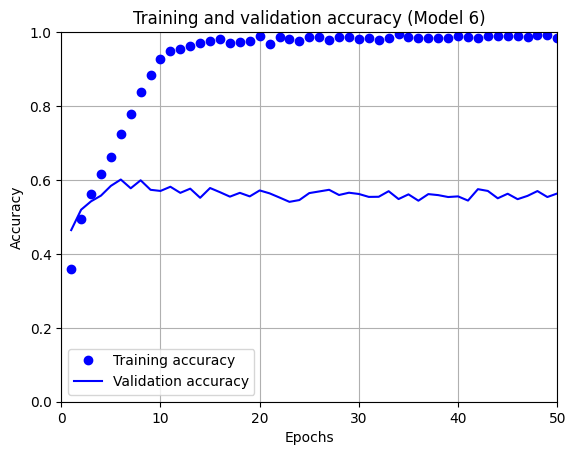

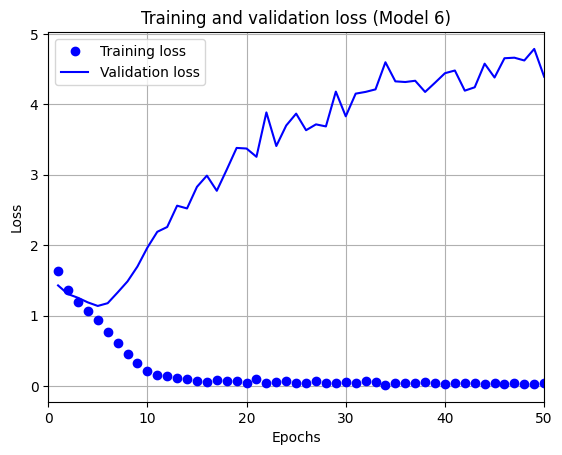

In [10]:
import matplotlib.pyplot as plt
acc6 = result6.history['accuracy']
val_acc6 = result6.history['val_accuracy']
loss6 = result6.history['loss']
val_loss6 = result6.history['val_loss']
epochs6 = range(1, len(acc6) + 1)

# Training and validation accuracy plot
plt.plot(epochs6, acc6, 'bo', label='Training accuracy')
plt.plot(epochs6, val_acc6, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs6, loss6, 'bo', label='Training loss')
plt.plot(epochs6, val_loss6, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()


## 